In [1]:
#%matplotlib inline

#%matplotlib widget
from mpl_toolkits import mplot3d
import pandas as pd
from openai.embeddings_utils import get_embedding
import openai
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.manifold import TSNE
import os
import PyPDF2 as pdf
from PyPDF2 import PdfReader
import warnings
warnings.filterwarnings('ignore')
import time


### OpenAI's Embedding API

In [2]:
api_key_file = open("OPENAI_API_KEY", "r")
openai.api_key = api_key_file.read()

In [3]:
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [4]:
def embed(x):
    return get_embedding(x, engine=embedding_model)

### PCA using a list of word embeddings

In [7]:
countries = (('AF', 'AFGHANISTAN'),('AL', 'ALBANIA'),('DZ', 'ALGERIA'),('AS', 'AMERICAN SAMOA'),('AD', 'ANDORRA'),('AO', 'ANGOLA'),('AI', 'ANGUILLA'),('AQ', 'ANTARCTICA'),('AG', 'ANTIGUA AND BARBUDA'),('AR', 'ARGENTINA'),('AM', 'ARMENIA'),('AW', 'ARUBA'),('AU', 'AUSTRALIA'),('AT', 'AUSTRIA'),('AZ', 'AZERBAIJAN'),('BS', 'BAHAMAS'),('BH', 'BAHRAIN'),('BD', 'BANGLADESH'),('BB', 'BARBADOS'),('BY', 'BELARUS'),('BE', 'BELGIUM'),('BZ', 'BELIZE'),('BJ', 'BENIN'),('BM', 'BERMUDA'),('BT', 'BHUTAN'),('BO', 'BOLIVIA'),('BA', 'BOSNIA AND HERZEGOVINA'),('BW', 'BOTSWANA'),('BV', 'BOUVET ISLAND'),('BR', 'BRAZIL'),('IO', 'BRITISH INDIAN OCEAN TERRITORY'),('BN', 'BRUNEI DARUSSALAM'),('BG', 'BULGARIA'),('BF', 'BURKINA FASO'),('BI', 'BURUNDI'),('KH', 'CAMBODIA'),('CM', 'CAMEROON'),('CA', 'CANADA'),('CV', 'CAPE VERDE'),('KY', 'CAYMAN ISLANDS'),('CF', 'CENTRAL AFRICAN REPUBLIC'),('TD', 'CHAD'),('CL', 'CHILE'),('CN', 'CHINA'),('CX', 'CHRISTMAS ISLAND'),('CC', 'COCOS (KEELING) ISLANDS'),('CO', 'COLOMBIA'),('KM', 'COMOROS'),('CG', 'CONGO'),('CD', 'CONGO, THE DEMOCRATIC REPUBLIC OF'),('CK', 'COOK ISLANDS'),('CR', 'COSTA RICA'),('CI', "CÃ”TE D'IVOIRE"),('HR', 'CROATIA'),('CU', 'CUBA'),('CY', 'CYPRUS'),('CZ', 'CZECH REPUBLIC'),('DK', 'DENMARK'),('DJ', 'DJIBOUTI'),('DM', 'DOMINICA'),('DO', 'DOMINICAN REPUBLIC'),('EC', 'ECUADOR'),('EG', 'EGYPT'),('SV', 'EL SALVADOR'),('GQ', 'EQUATORIAL GUINEA'),('ER', 'ERITREA'),('EE', 'ESTONIA'),('ET', 'ETHIOPIA'),('FK', 'FALKLAND ISLANDS (MALVINAS)'),('FO', 'FAROE ISLANDS'),('FJ', 'FIJI'),('FI', 'FINLAND'),('FR', 'FRANCE'),('GF', 'FRENCH GUIANA'),('PF', 'FRENCH POLYNESIA'),('TF', 'FRENCH SOUTHERN TERRITORIES'),('GA', 'GABON'),('GM', 'GAMBIA'),('GE', 'GEORGIA'),('DE', 'GERMANY'),('GH', 'GHANA'),('GI', 'GIBRALTAR'),('GR', 'GREECE'),('GL', 'GREENLAND'),('GD', 'GRENADA'),('GP', 'GUADELOUPE'),('GU', 'GUAM'),('GT', 'GUATEMALA'),('GN', 'GUINEA'),('GW', 'GUINEA'),('GY', 'GUYANA'),('HT', 'HAITI'),('HM', 'HEARD ISLAND AND MCDONALD ISLANDS'),('HN', 'HONDURAS'),('HK', 'HONG KONG'),('HU', 'HUNGARY'),('IS', 'ICELAND'),('IN', 'INDIA'),('ID', 'INDONESIA'),('IR', 'IRAN, ISLAMIC REPUBLIC OF'),('IQ', 'IRAQ'),('IE', 'IRELAND'),('IL', 'ISRAEL'),('IT', 'ITALY'),('JM', 'JAMAICA'),('JP', 'JAPAN'),('JO', 'JORDAN'),('KZ', 'KAZAKHSTAN'),('KE', 'KENYA'),('KI', 'KIRIBATI'),('KP', "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF"),('KR', 'KOREA, REPUBLIC OF'),('KW', 'KUWAIT'),('KG', 'KYRGYZSTAN'),('LA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC"),('LV', 'LATVIA'),('LB', 'LEBANON'),('LS', 'LESOTHO'),('LR', 'LIBERIA'),('LY', 'LIBYAN ARAB JAMAHIRIYA'),('LI', 'LIECHTENSTEIN'),('LT', 'LITHUANIA'),('LU', 'LUXEMBOURG'),('MO', 'MACAO'),('MK', 'MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF'),('MG', 'MADAGASCAR'),('MW', 'MALAWI'),('MY', 'MALAYSIA'),('MV', 'MALDIVES'),('ML', 'MALI'),('MT', 'MALTA'),('MH', 'MARSHALL ISLANDS'),('MQ', 'MARTINIQUE'),('MR', 'MAURITANIA'),('MU', 'MAURITIUS'),('YT', 'MAYOTTE'),('MX', 'MEXICO'),('FM', 'MICRONESIA, FEDERATED STATES OF'),('MD', 'MOLDOVA, REPUBLIC OF'),('MC', 'MONACO'),('MN', 'MONGOLIA'),('MS', 'MONTSERRAT'),('MA', 'MOROCCO'),('MZ', 'MOZAMBIQUE'),('MM', 'MYANMAR'),('NA', 'NAMIBIA'),('NR', 'NAURU'),('NP', 'NEPAL'),('NL', 'NETHERLANDS'),('AN', 'NETHERLANDS ANTILLES'),('NC', 'NEW CALEDONIA'),('NZ', 'NEW ZEALAND'),('NI', 'NICARAGUA'),('NE', 'NIGER'),('NG', 'NIGERIA'),('NU', 'NIUE'),('NF', 'NORFOLK ISLAND'),('MP', 'NORTHERN MARIANA ISLANDS'),('NO', 'NORWAY'),('OM', 'OMAN'),('PK', 'PAKISTAN'),('PW', 'PALAU'),('PS', 'PALESTINIAN TERRITORY, OCCUPIED'),('PA', 'PANAMA'),('PG', 'PAPUA NEW GUINEA'),('PY', 'PARAGUAY'),('PE', 'PERU'),('PH', 'PHILIPPINES'),('PN', 'PITCAIRN'),('PL', 'POLAND'),('PT', 'PORTUGAL'),('PR', 'PUERTO RICO'),('QA', 'QATAR'),('RE', 'RÃ‰UNION'),('RO', 'ROMANIA'),('RU', 'RUSSIAN FEDERATION'),('RW', 'RWANDA'),('SH', 'SAINT HELENA'),('KN', 'SAINT KITTS AND NEVIS'),('LC', 'SAINT LUCIA'),('PM', 'SAINT PIERRE AND MIQUELON'),('VC', 'SAINT VINCENT AND THE GRENADINES'),('WS', 'SAMOA'),('SM', 'SAN MARINO'),('ST', 'SAO TOME AND PRINCIPE'),('SA', 'SAUDI ARABIA'),('SN', 'SENEGAL'),('CS', 'SERBIA AND MONTENEGRO'),('SC', 'SEYCHELLES'),('SL', 'SIERRA LEONE'),('SG', 'SINGAPORE'),('SK', 'SLOVAKIA'),('SI', 'SLOVENIA'),('SB', 'SOLOMON ISLANDS'),('SO', 'SOMALIA'),('ZA', 'SOUTH AFRICA'),('GS', 'SOUTH GEORGIA AND SOUTH SANDWICH ISLANDS'),('ES', 'SPAIN'),('LK', 'SRI LANKA'),('SD', 'SUDAN'),('SR', 'SURINAME'),('SJ', 'SVALBARD AND JAN MAYEN'),('SZ', 'SWAZILAND'),('SE', 'SWEDEN'),('CH', 'SWITZERLAND'),('SY', 'SYRIAN ARAB REPUBLIC'),('TW', 'TAIWAN, PROVINCE OF CHINA'),('TJ', 'TAJIKISTAN'),('TZ', 'TANZANIA, UNITED REPUBLIC OF'),('TH', 'THAILAND'),('TL', 'TIMOR'),('TG', 'TOGO'),('TK', 'TOKELAU'),('TO', 'TONGA'),('TT', 'TRINIDAD AND TOBAGO'),('TN', 'TUNISIA'),('TR', 'TURKEY'),('TM', 'TURKMENISTAN'),('TC', 'TURKS AND CAICOS ISLANDS'),('TV', 'TUVALU'),('UG', 'UGANDA'),('UA', 'UKRAINE'),('AE', 'UNITED ARAB EMIRATES'),('GB', 'UNITED KINGDOM'),('US', 'UNITED STATES'),('UM', 'UNITED STATES MINOR OUTLYING ISLANDS'),('UY', 'URUGUAY'),('UZ', 'UZBEKISTAN'),('VU', 'VANUATU'),('VN', 'VIET NAM'),('VG', 'VIRGIN ISLANDS, BRITISH'),('VI', 'VIRGIN ISLANDS, U.S.'),('WF', 'WALLIS AND FUTUNA'),('EH', 'WESTERN SAHARA'),('YE', 'YEMEN'),('ZW', 'ZIMBABWE'))
countries = [i[1].lower() for i in list(countries)]
country_embeddings = np.array([embed(i) for i in countries])

RetryError: RetryError[<Future at 0x7fad74c229d0 state=finished raised RateLimitError>]

In [6]:
X = country_embeddings
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)
plt.figure(figsize=(50,50))
plt.scatter(X_embedded.T[0],X_embedded.T[1])
for i,txt in enumerate(countries):
            plt.text(x=X_embedded.T[0][i],y=X_embedded.T[1][i],s=txt,size=10)

NameError: name 'country_embeddings' is not defined

In [8]:
def PCA(words):
    embeddings = np.array([embed(i) for i in words])
    zipped = np.array(list(zip(words,embeddings)))
    eigenvectors = np.linalg.eigh(np.cov(embeddings.T))
    sorted_eigen = sorted(list(zip(eigenvectors[0],eigenvectors[1])), key = lambda x:x[0],reverse=True)
    df = pd.DataFrame({"word":[],"z1":[],"z2":[]})
    for i in zipped:
        word = i[0]
        z1 = np.dot(sorted_eigen[0][1],i[1])
        z2 = np.dot(sorted_eigen[1][1],i[1])
        df = df.append({"word":word,"z1":z1,"z2":z2},ignore_index=True)
    plt.figure(figsize = (30,30))
    sns.scatterplot(data=df, x = df['z1'], y = df['z2'])
    for i,txt in enumerate(df["word"]):
        plt.text(x=df["z1"][i],y=df["z2"][i],s=txt,size=10)
PCA(countries)

KeyboardInterrupt: 

### PCA with classification dataset from Kaggle (Breast Cancer)

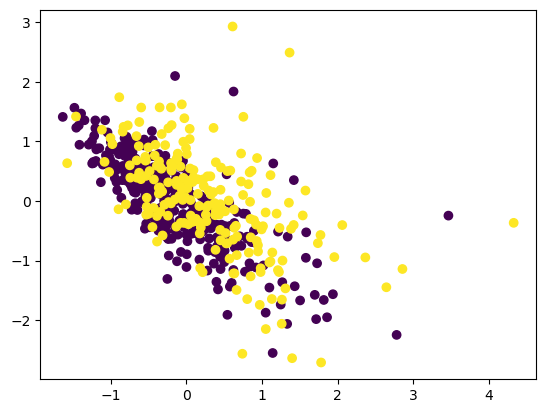

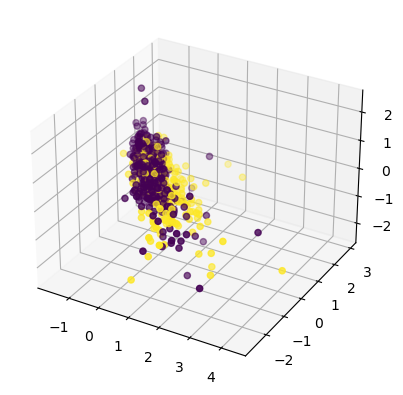

In [5]:
df = pd.read_csv('PCA Testing/brca.csv').set_index('Unnamed: 0')

X = df.drop(columns = ['y'])
X = X.apply(lambda x: (x - x.mean()) / x.std())
X = np.array(X)
y = np.array(df['y'])
y = np.array([True if i == "M" else False for i in y])

eigenvectors = np.linalg.eigh(np.cov(X.T))
sorted_eigen = sorted(list(zip(eigenvectors[0],eigenvectors[1])), key = lambda x:x[0],reverse=True)

u1 = sorted_eigen[0][1]
u2 = sorted_eigen[1][1]
u3 = sorted_eigen[2][1]

z1 = X@u1
z2 = X@u2
z3 = X@u3

plt.scatter(x = z1, y= z2, c = y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(z1, z2, z3, c=y);

### Guide Recommender from WikiHow Embeddings (Kaggle)

In [13]:
wikihow_df = pd.read_csv("Embedding Testing/articles.csv")
wikihow_df.head()

title  \
0  How to Take a Screenshot on a Windows PC: 8 Si...   
1                                  How to Play Poker   
2                                 How to French Kiss   
3  How to Clear Your Web Browser Cache on Any Pla...   
4                                        How to Kiss   

                                               intro  \
0  \nNeed to take a screenshot on your Windows PC...   
1  \nLooking to learn basic poker rules? Poker’s ...   
2  \nYou've seen it done in the movies and probab...   
3  \nWhile your browser cache usually helps websi...   
4  \nSo you finally got "the look" and you're mov...   

                                                body  co-authors  \
0  Go to the screen that you want to capture. Whe...         322   
1  Learn the 10 basic 5-card hands and their rank...         231   
2  Keep your lips soft. A soft, smooth, and sligh...         287   
3  Click the three-dot menu in Chrome ⋮. You'll s...         282   
4  Drop hints that you're interested. You can put...         310   

                  Updated     views  
0  Updated: June 11, 2023  36266016  
1   Updated: May 29, 2023   8112022  
2   Updated: May 30, 2023  28193317  
3  Updated: June 22, 2023  24232655  
4  Updated: June 27, 2023  33552860

In [15]:
wikihow_df["title"]

0      How to Take a Screenshot on a Windows PC: 8 Si...
1                                      How to Play Poker
2                                     How to French Kiss
3      How to Clear Your Web Browser Cache on Any Pla...
4                                            How to Kiss
                             ...                        
991        How to Get Rid of Aphids on Roses Organically
992             How to Fix a Peeling Clear Coat on a Car
993            How to Check and Add Power Steering Fluid
994    Chia Pet Instructions: Getting Started & Care ...
995                       How to Plan for a Long Weekend
Name: title, Length: 996, dtype: object

In [7]:
# Costly to run!
wikihow_df['string'] = wikihow_df['title'] + wikihow_df['intro'] + wikihow_df['body']
wikihow_embeddings = []
error = ''

for i in wikihow_df['string']:
    string = re.sub(r'{(.*?)}', '', i)
    try:
        wikihow_embeddings.append(embed(string))
        print("embedded")
    except:
        print("errored")
        error = string
        break
np.save("Embedding Testing/wkhw_embeddings.npy", np.array(wikihow_embeddings))

embedded
embedded
embedded
errored


In [11]:
np.dot(embed("League of legends"),embed("I love tft"))

0.7960835632541515

In [5]:
wikihow_embeddings_arr = np.load("Embedding Testing/wkhw_embeddings.npy")

In [6]:
wikihow_embeddings_arr

array([[-0.00505633, -0.01959365,  0.0167574 , ..., -0.00470025,
         0.0181074 ,  0.00984017],
       [-0.02613536,  0.00834107,  0.0168338 , ..., -0.00796193,
         0.00200154, -0.0407196 ],
       [ 0.00535854,  0.01854316,  0.05132483, ...,  0.0173078 ,
         0.00466445, -0.01183145],
       ...,
       [ 0.01038539,  0.00397886, -0.01297701, ...,  0.00694251,
        -0.02179229, -0.0016103 ],
       [-0.00322923,  0.01489415, -0.00420483, ...,  0.01118687,
        -0.01502423, -0.01663722],
       [ 0.0160779 ,  0.00454088,  0.0162099 , ...,  0.01173502,
         0.00939197, -0.04604245]])

In [12]:
def get_n_recommendations(prompt,n=10):
    prompt_embedding = embed(prompt)
    #Matrix Multiplication to calculate the dot product of each different article and the prompt
    dot_products = wikihow_embeddings_arr @ prompt_embedding
    wiki_zipped = np.array(list(zip(dot_products, wikihow_df["title"])))
    wiki_sorted = sorted(wiki_zipped,key=lambda x:x[0],reverse=True)
    return pd.DataFrame([(round(float(i[0]),2),i[1]) for i in wiki_sorted[0:n]]).rename(columns = {0:"Cosine Similarity",1:"Article Title"})

In [18]:
get_n_recommendations("How to speak chinese",30)

Cosine Similarity                                      Article Title
0                0.87                      How to Learn Mandarin Chinese
1                0.80                      How to Speak Spanish (Basics)
2                0.79                               How to Learn English
3                0.79                    How to Talk With a Deeper Voice
4                0.78  Easy Ways to Use Google Translate on Desktop a...
5                0.77  Holding Chopsticks Properly (With Asian Dining...
6                0.77                             How to Learn Wing Chun
7                0.77  How to Talk to a Girl You Like for the First Time
8                0.77  How to Use the Chinese Birth Gender Chart for ...
9                0.77                       How to Play the Card Game 13
10               0.77                   How to Speak in a British Accent
11               0.77                              How to Roll Your "R"s
12               0.77  Speak to a Real Person when Calling a Business...
13               0.77                                        How to Type
14               0.76                                        How to Sing
15               0.76                                       How to Spell
16               0.76                  How to Say How Are You in Spanish
17               0.76                     How to Say I Love You in Hindi
18               0.76          2 Ways to Change the Voice on Google Maps
19               0.76  Writing Shorthand: The Basics of the Teeline, ...
20               0.76  How to Say Good Morning in French with Pronunc...
21               0.76  How to Learn to Sing: Teach Yourself with 12 S...
22               0.76                      How to Feng Shui Your Bedroom
23               0.76                 How to Introduce Yourself in Class
24               0.76     How To Type Letters with Accents on a Computer
25               0.76              How to Change a Statement to Question
26               0.75                             How to Play Chopsticks
27               0.75  How to Keep the Conversation Flowing with a Gi...
28               0.75        How to Talk to Your Girlfriend on the Phone
29               0.75                                How to Play Mahjong

In [16]:
get_n_recommendations("I want to learn programming",10)

Cosine Similarity                                      Article Title
0               0.81                             How to Become a Hacker
1               0.80  How to Get ChatGPT to Write Effective Code & B...
2               0.78                                        How to Hack
3               0.77                      How to Speak Spanish (Basics)
4               0.77                       How to Build a Robot at Home
5               0.77                              How to Use a Computer
6               0.77                                    How to Be Smart
7               0.77                                        How to Type
8               0.76                           How to Improve Your Life
9               0.76           How to Watch Star Wars on Command Prompt

In [14]:
get_n_recommendations("How to fish",10)

Cosine Similarity                              Article Title
0               0.88                                How to Fish
1               0.84  How to Spool New Fishing Line Onto a Reel
2               0.83                       How to Fillet a Fish
3               0.82                        How to Play Go Fish
4               0.81                                How to Surf
5               0.81                      How to Swim Freestyle
6               0.81                  How to Enjoy the Outdoors
7               0.80                   How to Swing a Golf Club
8               0.80                How to Play Pool Like a Pro
9               0.80                                How to Swim

In [15]:
get_n_recommendations("Meow",10)

Cosine Similarity                                      Article Title
0               0.78        4 Easy Ways to Draw Cute and Realistic Cats
1               0.78                          How to Take Care of a Cat
2               0.77  How to Tell If Your Cat Is Pregnant & What to ...
3               0.75                  How to Keep Cats Out of Your Yard
4               0.75  Repelling Cats: Keep Ferals and Strays Out of ...
5               0.74                     How to Say I Love You in Hindi
6               0.74              How to Change a Statement to Question
7               0.74  How to Say Good Morning in French with Pronunc...
8               0.74  How to Do Cat’s Cradle and Similar String Desi...
9               0.73                             How to Meet New People

### PCA and TSNE for Clustering WikiHow Embeddings

In [85]:
def PCA_embeddings(embedding_arr):
    eigens = np.linalg.eigh(np.cov(embedding_arr.T))
    sorted_eigens = sorted(np.array(list(zip(eigens[0],eigens[1]))), key = lambda x:x[0], reverse=True)

    u1 = sorted_eigens[0][1]
    u2 = sorted_eigens[1][1]
    u3 = sorted_eigens[2][1]

    z1 = embedding_arr @ u1
    z2 = embedding_arr @ u2

    df = pd.DataFrame({"z1":z1,"z2":z2,"Article Title":wikihow_df["title"]})

    plt.figure(figsize=(100,100))
    plt.scatter(df["z1"],df["z2"])
    for i,txt in enumerate(df["Article Title"]):
            plt.text(x=df["z1"][i],y=df["z2"][i],s=txt,size=10)
            
PCA_embeddings(wikihow_embeddings_arr)

NameError: name 'df' is not defined

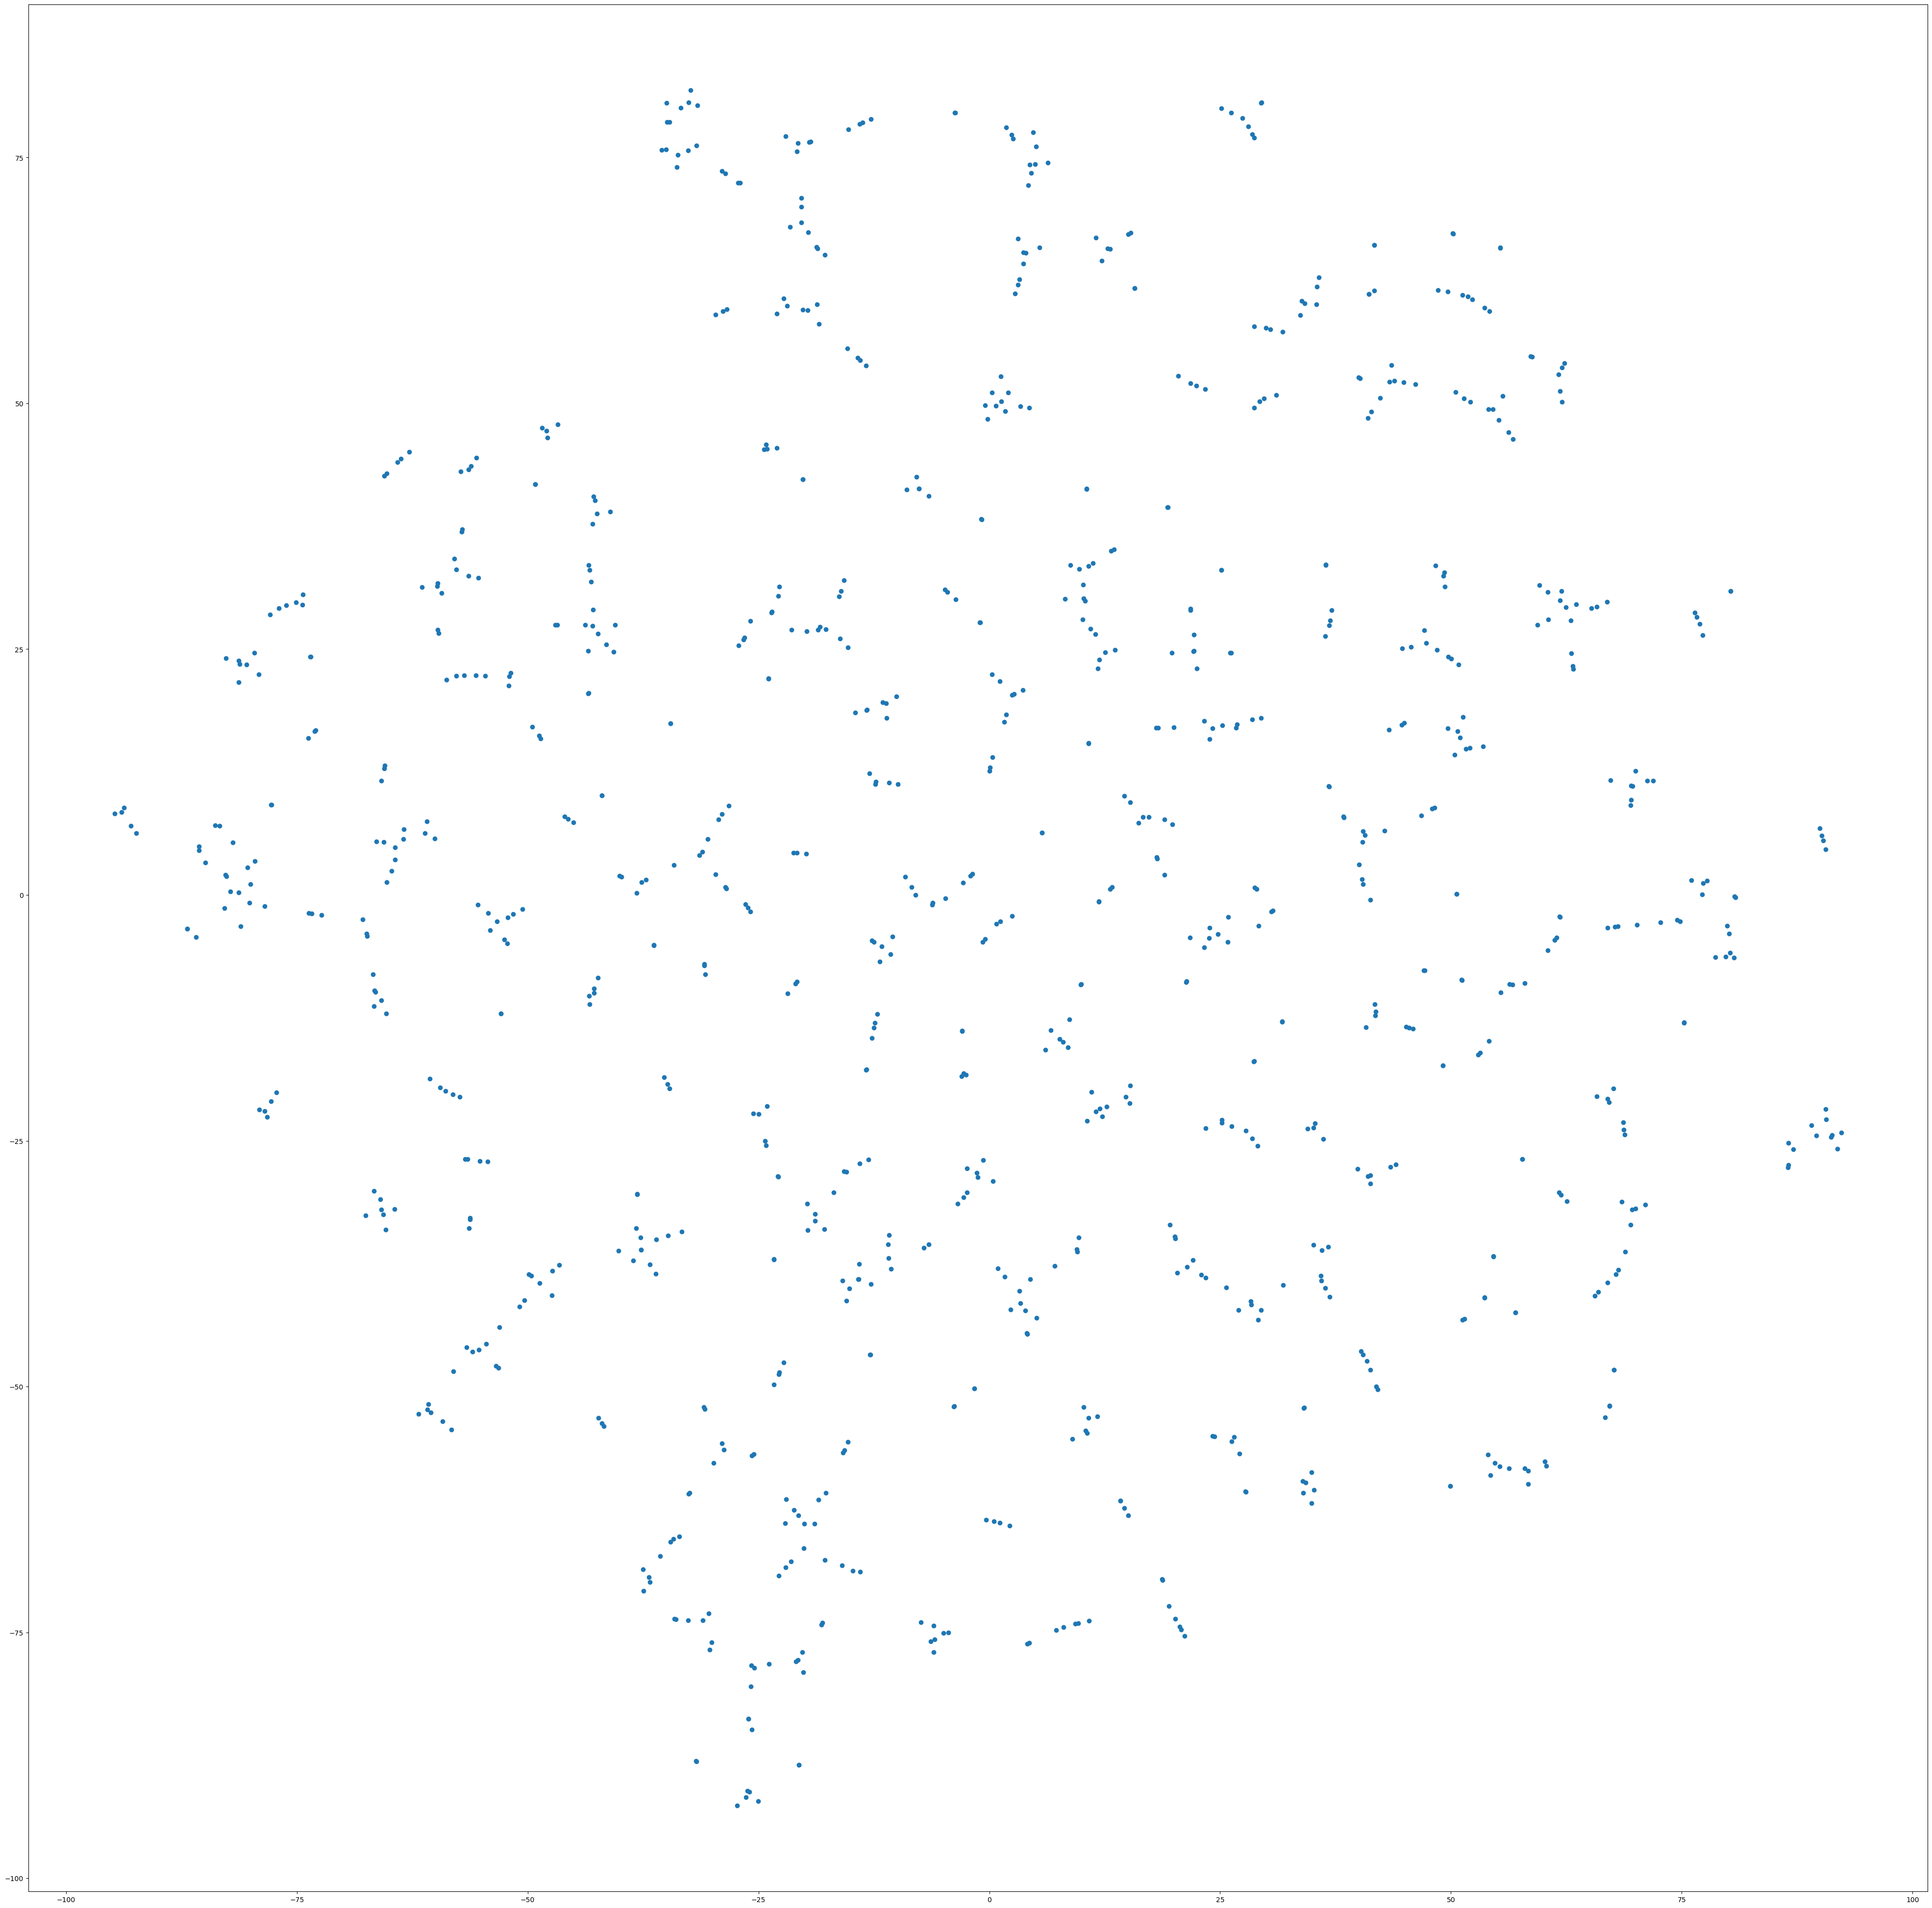

In [16]:
X = wikihow_embeddings_arr
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)
plt.figure(figsize=(50,50))
plt.scatter(X_embedded.T[0],X_embedded.T[1])
for i,txt in enumerate(df["Article Title"]):
            plt.text(x=X_embedded.T[0][i],y=X_embedded.T[1][i],s=txt,size=10)

### Pdf to Parseable

In [17]:
pdfs = os.listdir("pdfs")

pdf_df = pd.DataFrame({"file":[],"string":[]})

for i in pdfs:
    with open("pdfs/" + i,"rb") as file:
        reader = PdfReader(file)
        info = []
        for j in range(0, len(reader.pages)):
            info.append(reader.pages[j].extract_text())
            info.append(" ")
        string = ""
        for j in info:
            string = string+ ' '+ j

        pdf_df = pdf_df.append({"file":i,"string":string},ignore_index=True)
pdf_df.head()

incorrect startxref pointer(1)


file  \
0       Wi-Fi-6-OFDMA-App-Notes-091319-web.pdf   
1                                     STBC.pdf   
2  How to change the country code for WiFi.pdf   
3             SPF53_SPF61_programmer guide.pdf   
4       usb3-frequency-interference-papers.pdf   

                                              string  
0   © 2019 LitePoint, A Teradyne Company. \nAll r...  
1   A Study of the Next WLAN Standard\nIEEE 802.1...  
2   Title:HowtochangethecountrycodeforWiFi\n1:Pre...  
3   Qualcomm Technologies, Inc.\nConfidential and...  
4    \nDocument: 327216- 001  \n \n \n \n \n \nUS...

In [18]:
#Embedding the pdfs, ran into some issues with length and special characters

pdf_embeddings = []

def embed_pdf(string):
    cur_string = ' '.join(re.sub(r'(. . .)', '', string).replace("\n"," ").split())
    new_string = ""
    for i in cur_string:
        if i.isalnum() or i == " " or i == ".":
            new_string = new_string + i
    new_string = new_string.replace("ﬀ","ff")
    if len(new_string) >= 20000:
        return embed(new_string[0:20000])
    else:
        return embed(new_string)

for i in pdf_df["string"]:
    pdf_embeddings.append(embed_pdf(i))
    time.sleep(20)
pdf_embeddings = np.array(pdf_embeddings)

In [19]:
len(pdf_embeddings)

9

In [20]:
#Combining the pdfs and the wikihow dataset using the previous function
wikihow_and_pdfs = np.append(wikihow_embeddings_arr, pdf_embeddings, axis=0)

def wikihow_and_pdfs_get_n_recommendations(prompt,n=10):
    prompt_embedding = embed(prompt)
    #Matrix Multiplication to calculate the dot product of each different article and the prompt
    dot_products = wikihow_and_pdfs @ prompt_embedding
    wiki_zipped = np.array(list(zip(dot_products, list(wikihow_df["title"]) + list(pdf_df["file"]))))
    wiki_sorted = sorted(wiki_zipped,key=lambda x:x[0],reverse=True)
    return pd.DataFrame([(round(float(i[0]),2),i[1]) for i in wiki_sorted[0:n]]).rename(columns = {0:"Cosine Similarity",1:"Article Title"})




In [257]:
wikihow_and_pdfs_get_n_recommendations("wifi",n=50)


Cosine Similarity                                      Article Title
0                0.80         Easy Ways to Change the Wi-Fi Network Name
1                0.80             Wi-Fi-6-OFDMA-App-Notes-091319-web.pdf
2                0.79                                           STBC.pdf
3                0.79                       programming uci shrinked.pdf
4                0.79                                RadioChannelDFS.pdf
5                0.79  8 Easy Ways to Get Online Without Internet Ser...
6                0.79          10 Easy Steps to Set Up a Wireless Router
7                0.78        How to change the country code for WiFi.pdf
8                0.78                      FCC-Rules-and-Regulations.pdf
9                0.78             usb3-frequency-interference-papers.pdf
10               0.76                       How to Connect Two Computers
11               0.75       How to Detect a Remote Access to My Computer
12               0.74                         How to Find Hidden Cameras
13               0.74                         How to Find Hidden Cameras
14               0.74                How to Turn Your TV Into a Smart TV
15               0.74                                   How to Use a VPN
16               0.74       How to Find the IP Address of Your PC or Mac
17               0.74                How to Tell if Your Phone Is Tapped
18               0.74        6 Easy Ways to Watch YouTube Videos on a TV
19               0.74           How to Display the Secret Menu in LG TVs
20               0.73                          How to Enjoy the Outdoors
21               0.73                                        How to Hack
22               0.73           How to Watch Star Wars on Command Prompt
23               0.73  7 Simple Methods to Add Apps to a Smart TV (2022)
24               0.73                       How to Wear Wireless Earbuds
25               0.73  How to Improve JPEG Quality: 4 Tricks to Enhan...
26               0.73                      How to Find a Lost Cell Phone
27               0.73                   How to Find the URL of a Website
28               0.72                                  How to Be Healthy
29               0.72                              How to Use a Computer
30               0.72                          How to Be Sexy at Any Age
31               0.72                                     How to Use SSH
32               0.72                          How to Find a Lost iPhone
33               0.72  How To Use Your Android or iPhone as a Mic for...
34               0.72                         How to Play Dots and Boxes
35               0.72                          How to Use a Weed Whacker
36               0.72  How to Add, Use, and Share Tickets in Apple Wa...
37               0.72                               How to Make a Stylus
38               0.72               How to Know if You're Double Jointed
39               0.72              How to Transfer Files Between Laptops
40               0.72                                How to Touch a Girl
41               0.72                           nor_nand_flash_guide.pdf
42               0.72                       How to Copy and Paste a Link
43               0.72  2 Easy Ways to Add a Location or Business to G...
44               0.72  4 Ways to Block YouTube on a Computer, Phone, ...
45               0.72                           How to Improve Your Life
46               0.72  How to Do the Google Gravity Trick in Your Bro...
47               0.72                             How to Meet New People
48               0.72               How to Check Data Usage on an iPhone
49               0.72                  How to Check Your Hard Disk Space

In [79]:
def pdf_get_n_recommendations(prompt,n=10):
    prompt_embedding = embed(prompt)
    #Matrix Multiplication to calculate the dot product of each different article and the prompt
    dot_products = pdf_embeddings @ prompt_embedding
    pdf_zipped = np.array(list(zip(dot_products, list(pdf_df["file"]))))
    pdf_sorted = sorted(pdf_zipped,key=lambda x:x[0],reverse=True)
    return pd.DataFrame([(round(float(i[0]),2),i[1]) for i in pdf_sorted[0:n]]).rename(columns = {0:"Cosine Similarity",1:"Article Title"})

In [89]:
pdf_get_n_recommendations("NXP")

Cosine Similarity                                Article Title
0               0.79                     nor_nand_flash_guide.pdf
1               0.77             SPF53_SPF61_programmer guide.pdf
2               0.77       Wi-Fi-6-OFDMA-App-Notes-091319-web.pdf
3               0.75                 programming uci shrinked.pdf
4               0.75                          RadioChannelDFS.pdf
5               0.75                                     STBC.pdf
6               0.73       usb3-frequency-interference-papers.pdf
7               0.72  How to change the country code for WiFi.pdf
8               0.71                FCC-Rules-and-Regulations.pdf

### Processing Massive Documents

In [46]:
pdfs = os.listdir("pdfs")

pdf_df = pd.DataFrame({"file":[],"string":[]})

for i in pdfs:
    with open("pdfs/" + i,"rb") as file:
        reader = PdfReader(file)
        info = []
        for j in range(0, len(reader.pages)):
            info.append(reader.pages[j].extract_text())
            info.append(" ")
        string = ""
        for j in info:
            string = string+ ' '+ j

        pdf_df = pdf_df.append({"file":i,"string":string},ignore_index=True)
pdf_df.head()

incorrect startxref pointer(1)


file  \
0       Wi-Fi-6-OFDMA-App-Notes-091319-web.pdf   
1                                     STBC.pdf   
2  How to change the country code for WiFi.pdf   
3             SPF53_SPF61_programmer guide.pdf   
4       usb3-frequency-interference-papers.pdf   

                                              string  
0   © 2019 LitePoint, A Teradyne Company. \nAll r...  
1   A Study of the Next WLAN Standard\nIEEE 802.1...  
2   Title:HowtochangethecountrycodeforWiFi\n1:Pre...  
3   Qualcomm Technologies, Inc.\nConfidential and...  
4    \nDocument: 327216- 001  \n \n \n \n \n \nUS...

In [124]:
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_embeds():
    for i in range(20):
        try:
            embed(pdf_df["string"][3][0:22000])
        except:
            print("rate limit exceeded")
            time.sleep(20)
            embed(pdf_df["string"][3][0:22000])
        print("done")
run_embeds()

done
done
done
done
done
done
done
rate limit exceeded
done
done
rate limit exceeded
done
done
rate limit exceeded
done
done
rate limit exceeded
done
done
rate limit exceeded
done
done
rate limit exceeded
done
done
rate limit exceeded
done


SyntaxError: unexpected EOF while parsing (596763066.py, line 8)

In [105]:
from openai.error import RateLimitError
from tenacity. import RetryError

ImportError: cannot import name 'RetryError' from 'tenacity.retry' (/Users/houkinwan/opt/anaconda3/lib/python3.9/site-packages/tenacity/retry.py)

In [79]:
RetryError

NameError: name 'RetryError' is not defined

In [80]:
pdf_df["string"][3][0:20000]


NameError: name 'pdf_df' is not defined

In [126]:
!pip install tk

In [68]:
nums = [2, 8, 11, 15,40,41,50,51,52,53]
target = 10
import math

In [76]:
def find_two_numbers(nums, target):
    max = np.inf
    cur_threshold = 0
    while cur_threshold != len(nums):
        if nums[cur_threshold] > target:
            break
        elif cur_threshold == len(nums):
            break
        elif nums[cur_threshold] < target:
            cur_threshold = cur_threshold-1
        else:
            print(cur_threshold)
            cur_threshold = math.ceil((cur_threshold+len(nums))/2)
            
    print(nums[cur_threshold:])
    
    for i in range(cur_threshold):
        for j in range(i+1,cur_threshold):
            if (nums[i]+nums[j] == target):
                return (i,j)
        

In [78]:
find_two_numbers(nums,target)

[53]


In [87]:
!openai tools

usage: openai tools [-h] {fine_tunes.prepare_data} ...

optional arguments:
  -h, --help            show this help message and exit

Tools:
  {fine_tunes.prepare_data}
                        Convenience client side tools


usage: openai [-h] [-V] [-v] [-b API_BASE] [-k API_KEY] [-p PROXY [PROXY ...]]
              [-o ORGANIZATION]
              {api,tools,wandb} ...
openai: error: unrecognized arguments: Y


Empty DataFrame
Columns: [prompt, response]
Index: []

<OpenAIObject text_completion id=cmpl-7fdpV0dpDnL1agDUNXDBeAhi0ggwF at 0x7f7b82992d60> JSON: {
  "id": "cmpl-7fdpV0dpDnL1agDUNXDBeAhi0ggwF",
  "object": "text_completion",
  "created": 1690158909,
  "model": "curie:ft-personal-2023-07-21-11-18-01",
  "choices": [
    {
      "text": " \" hello \", line 1 prints the environment and two displays the character used so far",
      "index": 0,
      "logprobs": null,
      "finish_reason": "length"
    }
  ],
  "usage": {
    "prompt_tokens": 1,
    "completion_tokens": 16,
    "total_tokens": 17
  }
}

SyntaxError: invalid syntax (3008972087.py, line 1)